### Handle Imports

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import pymc as pm
import scipy.stats as stats
import aesara.tensor as T
from tqdm import tqdm
print(pm.__version__)
!nvidia-smi

4.1.7
Sun Aug 28 17:16:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:AF:00.0 Off |                  Off |
| 33%   28C    P8    15W / 260W |      1MiB / 24576MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

### Setup Sampling

In [ ]:
class PreferenceSampler():

    def __init__(self):
        self.initialized = False

    def setup_model(self, query_data, z_dim=2, noise_constant=0.01):
        # Define the model
        with pm.Model() as self.logistic_response_model:
            # Unpack query_data
            positives = np.array(query_data["positives"])
            negatives = np.array(query_data["negatives"])
            positives = pm.MutableData('positives', positives)
            negatives = pm.MutableData('negatives', negatives)
            num_queries = len(query_data["negatives"])
            
            A = 2 * (positives - negatives)
            tau = []
            for query_index in range(num_queries):
                positive = positives.get_value()[query_index]
                negative = negatives.get_value()[query_index]
                tau_val = (
                    pm.math.dot(positive, positive.get_value()) ** 2 - \
                    pm.math.dot(negative, negative.get_value()) ** 2
                )
                tau.append(tau_val)
            num_queries = len(query_data["negatives"])
            # Prior over latent space
            ideal_point_mean = np.zeros(z_dim)
            ideal_point_cov = np.eye(z_dim)
            ideal_point = pm.MvNormal("ideal_point", mu=ideal_point_mean, cov=ideal_point_cov, shape=2)
            logits = noise_constant * (pm.math.dot(A, ideal_point) - tau)
            # logits = logits.flatten()
            ones = np.ones((num_queries, 1))
            query_response_prob = pm.Bernoulli("query_response_prob", logit_p=logits, observed=ones)

    def sample_from_posterior_predictive(self, query_data, num_samples=500, z_dim=2, noise_constant=1,
                                        use_jax=True):
        """
        Use MCMC with NUTS Sampling to sample form the logistic_response_model 
        posterior predictive distribution
        """
        if not self.initialized:
            self.setup_model(query_data, z_dim=z_dim, noise_constant=noise_constant)
            self.initialized = True
            
        with self.logistic_response_model:
            pm.set_data({'positives': np.array(query_data["positives"])})
            pm.set_data({'negatives': np.array(query_data["negatives"])})
            # Decide whether or not to use JAX
            if False: # JAX doesn't work rn
                samples = pm.sampling_jax.sample_numpyro_nuts(2000, tune=2000, target_accept=0.9)
            else:
                samples = pm.sample(500)
                samples = samples.posterior["ideal_point"]
                print(samples)
                # samples = pm.sample_posterior_predictive(samples, return_inferencedata=False)

            return samples

### Setup Gaussian Experiment

In [ ]:
def make_2d_gaussian(num_samples=500):
    """Sample a 2D Gaussian"""
    mean = np.array([0, 0])
    cov = np.array([[1, 0], [0, 1]])

    return np.random.multivariate_normal(mean, cov, num_samples)

def answer_query(query, ground_truth, noise_std=1):
    """Returns index of query item closest to ground_truth with added noise"""
    item_a, item_b = query
    a_dist = np.linalg.norm(ground_truth - item_a)
    b_dist = np.linalg.norm(ground_truth - item_b)
    
    noise = np.random.normal(scale=noise_std)

    chosen_index = 0 if a_dist + noise < b_dist else 1
    positive = query[chosen_index]
    negative = query[not chosen_index]
    
    return positive, negative

def run_experiment_trial(num_queries=10, noise_std=1):
    """
        Runs a single experiment trial
        
        1. Sample random Gaussian
        2. Samples a random point as the ground truth
        3. For num_queries
            a. Sample a random query
            b. Answer the query
            c. Add to a list of query responses
        4. Sample from the posterior p(w|Q) using Pyro
        5. Compare to ground truth
        6. Return dataframe necessary to encapsulate the trial
    """
    # Make the sampler
    preference_sampler = PreferenceSampler()
    # 1. Sample random Gaussian
    gaussian_points = make_2d_gaussian()
    # 2. Samples a random point as ground truth 
    ground_truth = gaussian_points[0] # 0 index is as good as random
    # 3. Loop for "num_queries"
    ideal_point_estimates = []
    positives = []
    negatives = []
    all_posterior_samples = []
    for query_index in tqdm(range(num_queries)):
        # a. Sample a random query
        query_indices = np.random.choice(np.arange(len(gaussian_points)), size=2, replace=False)
        query = (gaussian_points[query_indices[0]], gaussian_points[query_indices[1]])
        # b. Answer the query
        positive, negative = answer_query(query, ground_truth, noise_std=noise_std)
        positives.append(positive)
        negatives.append(negative)
        # 4. Sample from the posterior p(w|Q)
        query_data = {
            "positives": positives,
            "negatives": negatives
        }
        posterior_samples = preference_sampler.sample_from_posterior_predictive(
            query_data, 
            num_samples=500, 
            z_dim=2
        )
        # Save data
        print(posterior_samples)
        # posterior_samples = posterior_samples["ideal_point"]
        ideal_point = np.mean(posterior_samples, axis=0)
        ideal_point_estimates.append(ideal_point)
        all_posterior_samples.append(posterior_samples)
        
    positives = np.array(positives)
    negatives = np.array(negatives)
    # 6. Return dataframe necessary to encapsulate the trial
    experiment_dict = {
        "gaussian_points": gaussian_points, 
        "ground_truth": ground_truth, 
        "positives": positives,
        "negatives": negatives,
        "ideal_points": ideal_point_estimates,
        "posterior_samples": all_posterior_samples
    }
    return experiment_dict

### Run Gaussian Experiment

In [ ]:
experiment_dict = run_experiment_trial(num_queries=5, noise_std=0.0)

  0%|          | 0/5 [00:00<?, ?it/s]


AttributeError: 'TensorVariable' object has no attribute 'get_value'

### Make Visualizations

In [102]:
def plot_queries(experiment_dict):
    """Plots queries in 2D space"""
    gaussian_points = experiment_dict["gaussian_points"]
    ground_truth = experiment_dict["ground_truth"]
    estimates = experiment_dict["ideal_points"]
    positives = experiment_dict["positives"]
    negatives = experiment_dict["negatives"]
    
    num_queries = len(estimates)
    # Plot Gaussians
    for query_index in range(num_queries - 1):
        fig, axs = plt.subplots(1, 1, dpi=100)
        axs.scatter(gaussian_points[:, 0], gaussian_points[:, 1], color="black")
        axs.scatter(ground_truth[0], ground_truth[1], color="green", marker="*")
        axs.scatter(estimates[query_index][0], estimates[query_index][1], color="red", marker="*")
        axs.scatter(positives[query_index][0], positives[query_index][1], color="green")
        axs.scatter(negatives[query_index][0], negatives[query_index][1], color="red")

        plt.show()

KeyError: 0

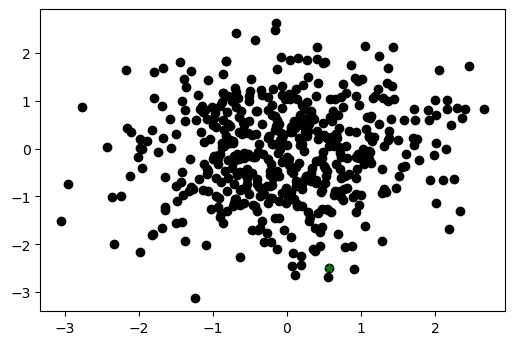

In [86]:
plot_queries(experiment_dict)

In [103]:
def plot_ground_truth_vs_estimate(experiment_dict):
    """Plots ground truth vs estimate"""
    gaussian_points = experiment_dict["gaussian_points"]
    ground_truth = experiment_dict["ground_truth"]
    estimates = experiment_dict["ideal_points"]
    num_queries = len(estimates)
    # Plot Gaussians
    fig, axs = plt.subplots(1, 1, dpi=100)
    axs.scatter(gaussian_points[:, 0], gaussian_points[:, 1], color="black")
    axs.scatter(ground_truth[0], ground_truth[1], color="green", marker="*")
    axs.scatter(estimates[-1][0], estimates[-1][1], color="red", marker="*")
    for query_index in range(num_queries - 1):
        x = [estimates[query_index][0], estimates[query_index + 1][0]]
        y = [estimates[query_index][1], estimates[query_index + 1][1]]
        line = Line2D(x, y, mfc='red', ms=12, label='line label')
        axs.add_line(line)


    plt.show()

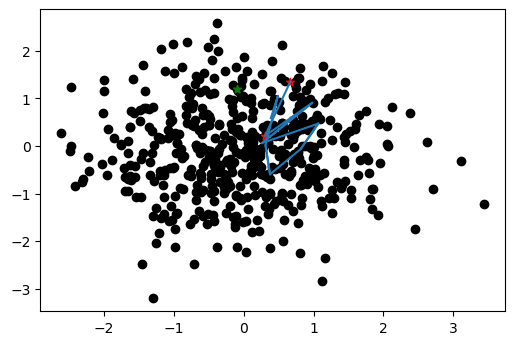

In [104]:
plot_ground_truth_vs_estimate(experiment_dict)

In [46]:
def plot_distance_over_time(experiment_dict):
    """
        Plots the distance of the estimates to the groudn truth over time. 
    """
    ground_truth_distances = np.linalg.norm(
        experiment_dict["ideal_points"] - experiment_dict["ground_truth"],
        axis=1
    )
    # Iterate through each query
    num_queries = len(experiment_dict["positives"])
    # Make a line plot
    fig = plt.figure()
    query_indices = np.arange(num_queries)
    plt.plot(query_indices, ground_truth_distances)
    plt.show()


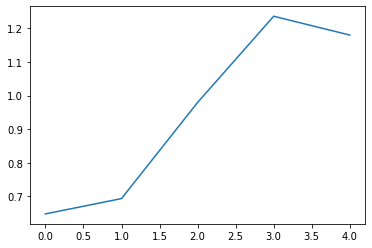

In [47]:
plot_distance_over_time(experiment_dict)

In [11]:
def plot_kendals_tau_distance(experiment_dict):
    """
        Gives a ranking distance between the optimal ranking and the
        estimated ranking. Ranking distance gives a metric that is 
        scale-invariant.
    """
    # Get the ground truth ranking
    ground_truth_distances = np.linalg.norm(
        experiment_dict["gaussian_points"] - experiment_dict["ground_truth"],
        axis=1
    )
    ground_truth_ranking = np.argsort(ground_truth_distances)
    # Iterate through each query
    num_queries = len(experiment_dict["positives"])
    kendalls_tau_distances = []
    for query_index in range(num_queries):
        # Get the estimated ranking
        ideal_point = experiment_dict["ideal_points"][query_index]
        estimated_distances = np.linalg.norm(
            experiment_dict["gaussian_points"] - ideal_point,
            axis=1
        )
        estimated_ranking = np.argsort(estimated_distances)
        # Compute the kendalls tau between the two
        kt_distance, value = stats.kendalltau(ground_truth_ranking, estimated_ranking)
        kendalls_tau_distances.append(kt_distance)
    # Make a line plot
    fig = plt.figure()
    query_indices = np.arange(num_queries)
    plt.plot(query_indices, kendalls_tau_distances)
    plt.show()

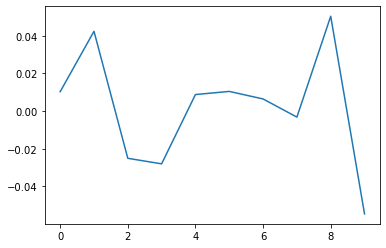

In [12]:
plot_kendals_tau_distance(experiment_dict)